### Import libraries 

In [1]:
import os
import random
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from PIL import Image 
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### Dataset 

In [2]:
root_dir = 'dataset'

In [3]:
class_folders = sorted(os.listdir(root_dir))
print(class_folders)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [4]:
classes = {}

for i, folder_name in enumerate(class_folders):
    classes[i] = folder_name

print(classes)

{0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}


In [5]:


# duyệt qua từng cặp idx va class name (folder class) 
class_dirs = {}
for label_idx, class_name in classes.items():
    # Tạo đường dẫn đến thư mục chứa ảnh  từng class
    class_dirs[label_idx] = os.path.join(root_dir, class_name)


class_dirs


{0: 'dataset\\dew',
 1: 'dataset\\fogsmog',
 2: 'dataset\\frost',
 3: 'dataset\\glaze',
 4: 'dataset\\hail',
 5: 'dataset\\lightning',
 6: 'dataset\\rain',
 7: 'dataset\\rainbow',
 8: 'dataset\\rime',
 9: 'dataset\\sandstorm',
 10: 'dataset\\snow'}

In [6]:
img_paths = []
labels = []

# duyệt qua từng thư mục và lấy danh sách ảnh
for label_idx, class_dir in class_dirs.items():
    # Duyệt qua từng ảnh trong thư mục hiện tại
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        
        img_paths.append(img_path)
        labels.append(label_idx)

img_paths[0:5], labels[0:5]
        

(['dataset\\dew\\2208.jpg',
  'dataset\\dew\\2209.jpg',
  'dataset\\dew\\2210.jpg',
  'dataset\\dew\\2211.jpg',
  'dataset\\dew\\2212.jpg'],
 [0, 0, 0, 0, 0])

In [7]:
#  Chia dữ liệu ban đầu thành Train (80%) - Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    img_paths,         
    labels,            
    test_size=0.2, 
    random_state=0,
    shuffle=True
)


# Chia tiếp tập Train thành Train (70%) - Test (10%)
X_train, X_test, y_train, y_test = train_test_split(
    X_train,          
    y_train,           
    test_size=0.125, 
    random_state=0, 
    shuffle=True
)

In [8]:
def transform(img, img_size= (224, 224)):
    img = img.resize(img_size)
    img =np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float() #huyển đổi kênh màu (C, H, W), 
    normalized_img = img/255
    return normalized_img


class CustomDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform 

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        
        return img, self.labels[index]


In [9]:
train_dataset = CustomDataset(
    X_train, y_train,
    transform= transform
)


val_dataset = CustomDataset(
    X_val, y_val,
    transform= transform
)

train_dataset = CustomDataset(
    X_test, y_test,
    transform= transform
)


In [10]:
# Dataloader

train_batchsize = 512

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batchsize,
    shuffle=True
)


val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)


test_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False
)

In [11]:
train_features, train_labels = next(iter(train_loader))
train_features.size(), train_labels.size()

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

### ResNet Model 

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        # Tạo downsample cho shortcut nếu cần
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = self.downsample(x)  # Xử lý shortcut để khớp kích thước nếu cần
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        
        x += shortcut  # Cộng với shortcut đã được xử lý
        x = self.relu(x)
        
        return x


In [13]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)


    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)
        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        
        return x



In [14]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
)


### Evaluate Function

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc


### Train function

In [16]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        # Training phase
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Validation phase
        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}")

    return train_losses, val_losses


### Train Model

In [17]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)


In [18]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)


EPOCH 1:	Train loss: 2.3388	Val loss: 2.3965
EPOCH 2:	Train loss: 1.7989	Val loss: 2.3919
EPOCH 3:	Train loss: 1.4653	Val loss: 2.3880
EPOCH 4:	Train loss: 1.2407	Val loss: 2.3859
EPOCH 5:	Train loss: 1.0185	Val loss: 2.3856
EPOCH 6:	Train loss: 0.8500	Val loss: 2.3847
EPOCH 7:	Train loss: 0.6841	Val loss: 2.3840
EPOCH 8:	Train loss: 0.5717	Val loss: 2.3852
EPOCH 9:	Train loss: 0.4956	Val loss: 2.3855
EPOCH 10:	Train loss: 0.4260	Val loss: 2.3862
EPOCH 11:	Train loss: 0.3607	Val loss: 2.3889
EPOCH 12:	Train loss: 0.2968	Val loss: 2.3922
EPOCH 13:	Train loss: 0.1966	Val loss: 2.3756
EPOCH 14:	Train loss: 0.1429	Val loss: 2.3547
EPOCH 15:	Train loss: 0.1130	Val loss: 2.3366
EPOCH 16:	Train loss: 0.0967	Val loss: 2.3093
EPOCH 17:	Train loss: 0.0879	Val loss: 2.2531
EPOCH 18:	Train loss: 0.0791	Val loss: 2.1740
EPOCH 19:	Train loss: 0.0773	Val loss: 2.0868
EPOCH 20:	Train loss: 0.0629	Val loss: 2.0163
EPOCH 21:	Train loss: 0.0524	Val loss: 1.9226
EPOCH 22:	Train loss: 0.0530	Val loss: 1.81

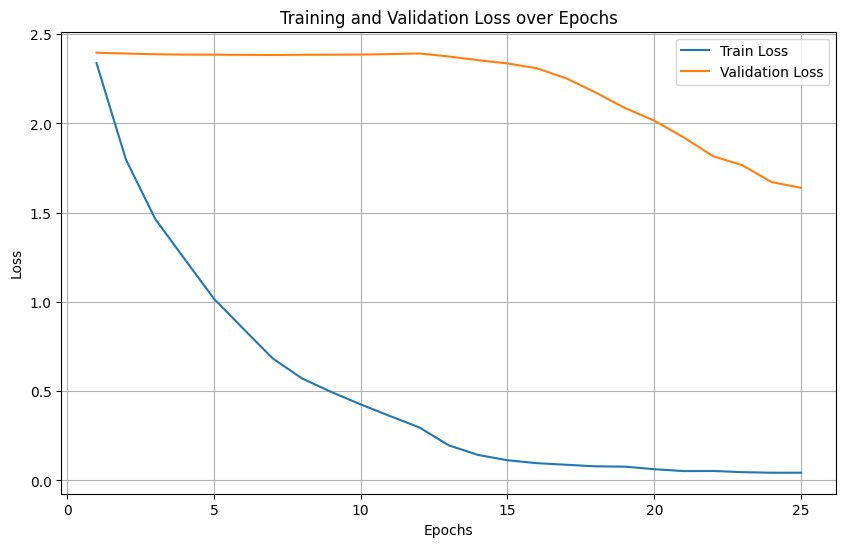

In [20]:
# Vẽ đồ thị train loss và val loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Đánh giá mô hình trên tập val
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

# Đánh giá mô hình trên tập test
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

# In kết quả đánh giá
print('Evaluation on val / test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)


Evaluation on val / test dataset
Val accuracy: 0.4668608885651857
Test accuracy: 0.8442503639010189


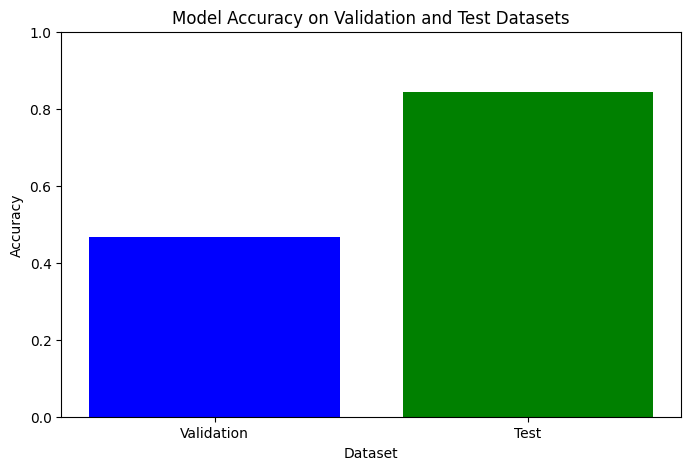

In [22]:
accuracies = [val_acc, test_acc]
datasets = ['Validation', 'Test']

# Vẽ đồ thị accuracy
plt.figure(figsize=(8, 5))
plt.bar(datasets, accuracies, color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Validation and Test Datasets')
plt.ylim(0, 1)  # Đảm bảo trục Y nằm trong khoảng [0, 1]
plt.show()

In [27]:
# Chuyển mô hình sang TorchScript và lưu lại
scripted_model = torch.jit.script(model)
scripted_model.save('resnet_model_scripted.pt')
